# Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

## Подготовка

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
try:
    data = pd.read_csv(r"C:\Users\kuzmi\Downloads\toxic_comments.csv")
except:    
    data = pd.read_csv(r'/datasets/toxic_comments.csv')

In [ ]:
data.info()

In [ ]:
data.head(10)

In [ ]:
display(data['toxic'].value_counts())
class_ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
class_ratio

In [ ]:
data['text'] = data['text'].str.lower()

In [ ]:
data_new = []
pattern = r'[^a-zA-Z0-9]' 
for sentence in data.text:
    cleared_text = re.sub(pattern, " ", sentence)
    data_new.append(" ". join(cleared_text.split()))
     

In [ ]:
data["clear_text"]=data_new
data.head()

In [ ]:
sample_size = 20000
corpus = data.sample(n=sample_size,random_state=0).reset_index(drop=True)
print('соотношение классов в датасете corpus\n', corpus.toxic.value_counts()/corpus.shape[0]*100)

Классы несбалансированы, сбалансируем их разными способами, и выберем лучший

In [ ]:
L = WordNetLemmatizer()

def lemmatizered(corpus):
    corpus_new = []
    for sentence in corpus:
        word_list = nltk.word_tokenize(sentence)
        corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
    return corpus_new

In [ ]:
nltk.download('stopwords')
stopwords.words('english')[:5]

In [ ]:
def get_wordnet_pos(word):
    #функция возвращает словарь, где возвращается значение часть речи (pos_tag)
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def get_word_text(corpus):
    corpus_new = []
    for sentence in corpus:
        corpus_new.append(' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
    return corpus_new

In [ ]:
 %%time
corpus['lemma_text'] = get_word_text(corpus['clear_text'])

In [ ]:
corpus.head()

In [ ]:
target = corpus['toxic']
features = corpus.drop(['toxic'], axis=1)


features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.5, 
                                                                              random_state=1515)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=1515)

In [ ]:
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemma_text'].values.astype('object'))
features_valid = count_tf_idf.transform(features_valid['lemma_text'].values.astype('object'))
features_test = count_tf_idf.transform(features_test['lemma_text'].values.astype('object'))
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts=3

In [ ]:
model_lr = LogisticRegression()
train_f1 = cross_val_score(model_lr, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

### Балансировка данных

#### Автоматическая балансировка классов

In [ ]:
model_lr = LogisticRegression(class_weight='balanced')
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))

#### Увеличение меньшего класса

#def upsample(features, target, repeat):
repeat=3
features_zeros = features[target == 0]
features_ones = features[target == 1]
target_zeros = target[target == 0]
target_ones = target[target == 1]

features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
features_upsampled, target_upsampled = shuffle(
features_upsampled, target_upsampled, random_state=12345)
    #return features_upsampled, target_upsampled
   

#features_upsampled, target_upsampled = upsample(features_train, target_train, 3) 
model = LogisticRegression()
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print("Accuracy:", accuracy_score(predicted_valid, target_valid))
print("F1:", f1_score(target_valid, predicted_valid))

#### Уменьшение весов

In [20]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.6768850602524378


In [21]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.6768850602524378


Видим прирост значения F1 

### Вывод
Выборка была разделена на обучающую, валидационную и тестовую выборки.
Была произведена балансировка данных, ресемплирование показало лучший результат

## Обучение

### LogisticRegression

In [22]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}

Grid scores on development set:

0.666981 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.666981 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.665972 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.676885 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.676885 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.677558 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.680437 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.680437 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.680437 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver

In [23]:
classificator = LogisticRegression(class_weight='balanced')
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.6804367901863654
F1 на валидации 0.7089151450053706


### DecisionTreeClassifier

In [24]:
%%time
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[1515],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 1515}

Grid scores on development set:

0.555338 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 50, 'random_state': 1515}
0.559212 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 52, 'random_state': 1515}
0.555149 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 54, 'random_state': 1515}
0.553089 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 56, 'random_state': 1515}
0.555937 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 58, 'random_state': 1515}
0.553860 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 60, 'random_state': 1515}
0.550768 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 62, 'random_state': 1515}
0.562403 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 1515}
0

In [25]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.5624028050287043
F1 на валидации 0.5606523955147807


### CatBoostClassifier

In [26]:
classificator = CatBoostClassifier(verbose=False, iterations=250)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.6265549046546663
F1 на валидации 0.657997399219766


In [27]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.680437,0.708915,False
DecisionTreeClassifier,0.562403,0.560652,False
CatBoostClassifier,0.626555,0.657997,False


### Вывод
Лучшая модель - LogisticRegression, ее будем проверять на тестовых данных

Метрики LogisticRegression
ROC AUC: 0.9531156444550247
F1: 0.7301587301587301
Precision: 0.7615894039735099
Recall: 0.7012195121951219
Accuracy: 0.949



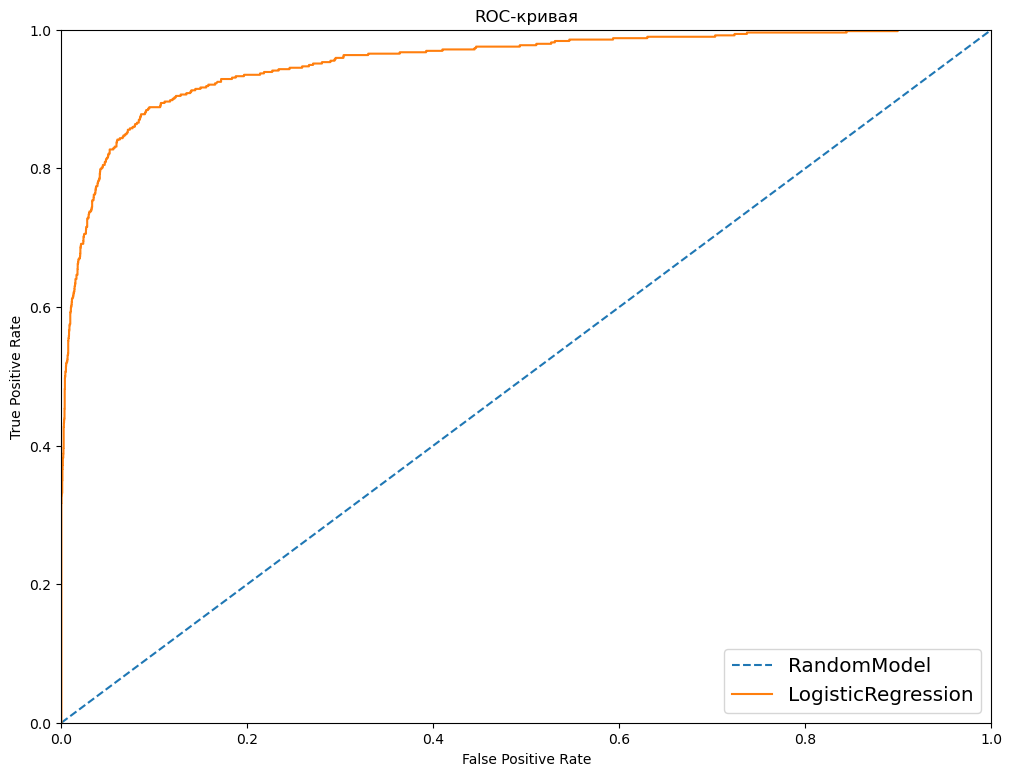

In [28]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()


## Вывод

Подготовлены данные обучения.

Выбран способ баланса классов, сформированы обучающая, валидационная и тестовая выборка.

Обучены модели и выбрана лучшая из них на валидационной выборке.

Показаны параметры качества моделей.

Лучшая модель стала LogisticRegression.
